# A Framework for Rapid Prototyping Data-Science Modelling of COVID-19 Data with Countries Statistics

In [1]:
import sys
!{sys.executable} -m pip install wbdata
!{sys.executable} -m pip install world_bank_data
!{sys.executable} -m pip install covid
!{sys.executable} -m pip install pycountry
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install shap

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sys
import os
import multiprocessing

import numpy as np
import datetime
import re
import pickle

# For Import Data
import wbdata
import world_bank_data as wb
from covid import Covid

# For Getting alpha_3 country code
import pycountry

# For Data Preparation and Structuring
import pandas as pd
import json

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Supporting Machine Learning Modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

# For Machine Learning Modelling
import lightgbm as lgb

# For Feature Analysing and Reasoning of the Model
import shap

In [3]:
work_dir = os.getcwd()
sys.path.append(work_dir)
os.chdir(work_dir)

In [4]:
work_dir

'/home/ec2-user/SageMaker'

# Explore World Bank Data

## Analysing world_bank_data API

In [5]:
# Reference: https://github.com/mwouts/world_bank_data

In [6]:
wb.get_topics()

,value,sourceNote
id,,
1,Agriculture & Rural Development,For the 70 percent of the world's poor who liv...
2,Aid Effectiveness,Aid effectiveness is the impact that aid has i...
3,Economy & Growth,Economic growth is central to economic develop...
4,Education,Education is one of the most powerful instrume...
5,Energy & Mining,The world economy needs ever-increasing amount...
6,Environment,Natural and man-made environmental resources –...
7,Financial Sector,An economy's financial markets are critical to...
8,Health,Improving health is central to the Millennium ...
9,Infrastructure,Infrastructure helps determine the success of ...


In [7]:
wb.get_sources().head()

,lastupdated,name,code,description,url,dataavailability,metadataavailability,concepts
id,,,,,,,,
1,2019-10-23,Doing Business,DBS,,,Y,Y,3
2,2020-04-09,World Development Indicators,WDI,,,Y,Y,3
3,2019-11-07,Worldwide Governance Indicators,WGI,,,Y,Y,3
5,2016-03-21,Subnational Malnutrition Database,SNM,,,Y,Y,3
6,2019-12-02,International Debt Statistics,IDS,,,Y,Y,3


In [8]:
countries = wb.get_countries()
wb_countries = countries.loc[(countries['region'] != 'Aggregates') & (countries['longitude'].notna())]
wb_countries.head()

,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
id,,,,,,,,,
ABW,AW,Aruba,Latin America & Caribbean,,High income,Not classified,Oranjestad,-70.0167,12.51670
AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280
AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155
ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170
AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750


In [9]:
wb.get_topics().shape

(21, 2)

In [10]:
data_dates = (datetime.datetime(2015,1,1), datetime.datetime(2020,1,1))

In [11]:
data = wbdata.get_dataframe({'FP.CPI.TOTL.ZG': 'value'}, 
                            country='all', 
                            data_date=data_dates, 
                            convert_date=False, keep_levels=True)

In [12]:
data.head(10)

value
country                date          
Arab World             2019       NaN
                       2018  2.275378
                       2017  1.781993
                       2016  1.844391
                       2015  1.814077
Caribbean small states 2019       NaN
                       2018  1.282843
                       2017  1.892520
                       2016  0.488912
                       2015 -0.679638

In [13]:
wb.get_indicators(topic=8).reset_index().head() # Topic 8: Health

,id,name,unit,source,sourceNote,sourceOrganization,topics
0,SG.VAW.1549.ZS,Proportion of women subjected to physical and/...,,World Development Indicators,Proportion of women subjected to physical and/...,United Nations Statistics Division (UNSD),"Health ,Gender"
1,SG.VAW.ARGU.ZS,Women who believe a husband is justified in be...,,World Development Indicators,Percentage of women ages 15-49 who believe a h...,"Demographic and Health Surveys (DHS), Multiple...","Health ,Gender"
2,SG.VAW.BURN.ZS,Women who believe a husband is justified in be...,,World Development Indicators,Percentage of women ages 15-49 who believe a h...,"Demographic and Health Surveys (DHS), Multiple...","Health ,Gender"
3,SG.VAW.GOES.ZS,Women who believe a husband is justified in be...,,World Development Indicators,Percentage of women ages 15-49 who believe a h...,"Demographic and Health Surveys (DHS), Multiple...","Health ,Gender"
4,SG.VAW.NEGL.ZS,Women who believe a husband is justified in be...,,World Development Indicators,Percentage of women ages 15-49 who believe a h...,"Demographic and Health Surveys (DHS), Multiple...","Health ,Gender"


## Select the Preferred Features

In [14]:
indicators_list = wb.get_indicators(topic=1).reset_index()
indicators_list.drop(indicators_list.index, inplace=True)

# for i in range(21): # For Select All 21 Topics
topics = [8] # Select Health: Topic 8
for i in topics:
    temp = wb.get_indicators(topic=i).reset_index()
    print(i, temp.shape)
    indicators_list = pd.concat([indicators_list, temp], ignore_index=True)

8 (634, 7)


In [15]:
indicators_list.shape

(634, 7)

In [16]:
indicators_list.topics.value_counts()

Health                                                                      549
Health ,Gender                                                               30
Health ,Environment                                                          23
Health ,Gender,Social Development                                             5
Health ,Aid Effectiveness                                                     3
Health ,Climate Change                                                        3
Health ,Urban Development                                                     2
Education ,Health                                                             2
Health ,Aid Effectiveness ,Climate Change                                     2
Financial Sector ,Health                                                      2
Health ,Social Development                                                    2
Health ,Gender,Aid Effectiveness                                              2
Climate Change,Health                   

# ETL and Structuring of the World Bank Data based on the Selected Topic/s

### Identify the Clean Features

In [17]:
df_dict = indicators_list[['id', 'id']]
df_dict.columns = ["key", "value"]

valid_features = []
for i in range(indicators_list.shape[0]):
    print(i)
    temp = df_dict[i:i+1][:]
    print(temp)
    col_dict = temp.set_index('key')['value'].to_dict()
    
    try:
        wbdata.get_dataframe(col_dict, country='all', data_date=data_dates)
        valid_features.append(i)
    except ValueError: 
        print("a ValueError occurred")
    except NameError:
        print("a NameError occurred")
    except:
        print("some other error occurred")

0
              key           value
0  SG.VAW.1549.ZS  SG.VAW.1549.ZS
1
              key           value
1  SG.VAW.ARGU.ZS  SG.VAW.ARGU.ZS
2
              key           value
2  SG.VAW.BURN.ZS  SG.VAW.BURN.ZS
3
              key           value
3  SG.VAW.GOES.ZS  SG.VAW.GOES.ZS
4
              key           value
4  SG.VAW.NEGL.ZS  SG.VAW.NEGL.ZS
5
              key           value
5  SG.VAW.REAS.ZS  SG.VAW.REAS.ZS
6
              key           value
6  SG.VAW.REFU.ZS  SG.VAW.REFU.ZS
7
                 key              value
7  SH.ACS.ALON.Q1.ZS  SH.ACS.ALON.Q1.ZS
8
                 key              value
8  SH.ACS.ALON.Q2.ZS  SH.ACS.ALON.Q2.ZS
9
                 key              value
9  SH.ACS.ALON.Q3.ZS  SH.ACS.ALON.Q3.ZS
10
                  key              value
10  SH.ACS.ALON.Q4.ZS  SH.ACS.ALON.Q4.ZS
11
                  key              value
11  SH.ACS.ALON.Q5.ZS  SH.ACS.ALON.Q5.ZS
12
                  key              value
12  SH.ACS.DIST.Q1.ZS  SH.ACS.DIST.Q1.ZS
13
      

103
                   key              value
103  SH.FPL.HEAR.Q5.ZS  SH.FPL.HEAR.Q5.ZS
104
                key           value
104  SH.FPL.IDLC.Q1  SH.FPL.IDLC.Q1
105
                key           value
105  SH.FPL.IDLC.Q2  SH.FPL.IDLC.Q2
106
                key           value
106  SH.FPL.IDLC.Q3  SH.FPL.IDLC.Q3
107
                key           value
107  SH.FPL.IDLC.Q4  SH.FPL.IDLC.Q4
108
                key           value
108  SH.FPL.IDLC.Q5  SH.FPL.IDLC.Q5
109
                   key              value
109  SH.FPL.KNOW.Q1.ZS  SH.FPL.KNOW.Q1.ZS
110
                   key              value
110  SH.FPL.KNOW.Q2.ZS  SH.FPL.KNOW.Q2.ZS
111
                   key              value
111  SH.FPL.KNOW.Q3.ZS  SH.FPL.KNOW.Q3.ZS
112
                   key              value
112  SH.FPL.KNOW.Q4.ZS  SH.FPL.KNOW.Q4.ZS
113
                   key              value
113  SH.FPL.KNOW.Q5.ZS  SH.FPL.KNOW.Q5.ZS
114
                   key              value
114  SH.FPL.KWMD.Q1.ZS  SH.FPL.KWMD.Q1.ZS
115


200
                key           value
200  SH.MED.NUMW.P3  SH.MED.NUMW.P3
201
                key           value
201  SH.MED.PHYS.ZS  SH.MED.PHYS.ZS
202
                key           value
202  SH.MED.SAOP.P5  SH.MED.SAOP.P5
203
             key        value
203  SH.MLR.INCD  SH.MLR.INCD
a ValueError occurred
204
                key           value
204  SH.MLR.INCD.P3  SH.MLR.INCD.P3
205
                   key              value
205  SH.MLR.NETA.Q1.ZS  SH.MLR.NETA.Q1.ZS
206
                   key              value
206  SH.MLR.NETA.Q2.ZS  SH.MLR.NETA.Q2.ZS
207
                   key              value
207  SH.MLR.NETA.Q3.ZS  SH.MLR.NETA.Q3.ZS
208
                   key              value
208  SH.MLR.NETA.Q4.ZS  SH.MLR.NETA.Q4.ZS
209
                   key              value
209  SH.MLR.NETA.Q5.ZS  SH.MLR.NETA.Q5.ZS
210
                   key              value
210  SH.MLR.NETH.Q1.ZS  SH.MLR.NETH.Q1.ZS
211
                   key              value
211  SH.MLR.NETH.Q2.ZS  SH.MLR.NETH.

296
                   key              value
296  SH.STA.BFED.Q1.ZS  SH.STA.BFED.Q1.ZS
297
                   key              value
297  SH.STA.BFED.Q2.ZS  SH.STA.BFED.Q2.ZS
298
                   key              value
298  SH.STA.BFED.Q3.ZS  SH.STA.BFED.Q3.ZS
299
                   key              value
299  SH.STA.BFED.Q4.ZS  SH.STA.BFED.Q4.ZS
300
                   key              value
300  SH.STA.BFED.Q5.ZS  SH.STA.BFED.Q5.ZS
301
                key           value
301  SH.STA.BFED.ZS  SH.STA.BFED.ZS
302
                   key              value
302  SH.STA.BRTC.Q1.ZS  SH.STA.BRTC.Q1.ZS
303
                   key              value
303  SH.STA.BRTC.Q2.ZS  SH.STA.BRTC.Q2.ZS
304
                   key              value
304  SH.STA.BRTC.Q3.ZS  SH.STA.BRTC.Q3.ZS
305
                   key              value
305  SH.STA.BRTC.Q4.ZS  SH.STA.BRTC.Q4.ZS
306
                   key              value
306  SH.STA.BRTC.Q5.ZS  SH.STA.BRTC.Q5.ZS
307
                key           value
307 

392
                   key              value
392  SH.STA.STNT.Q3.ZS  SH.STA.STNT.Q3.ZS
393
                   key              value
393  SH.STA.STNT.Q4.ZS  SH.STA.STNT.Q4.ZS
394
                   key              value
394  SH.STA.STNT.Q5.ZS  SH.STA.STNT.Q5.ZS
395
                key           value
395  SH.STA.STNT.ZS  SH.STA.STNT.ZS
396
                   key              value
396  SH.STA.SUIC.FE.P5  SH.STA.SUIC.FE.P5
397
                   key              value
397  SH.STA.SUIC.MA.P5  SH.STA.SUIC.MA.P5
398
                key           value
398  SH.STA.SUIC.P5  SH.STA.SUIC.P5
399
                key           value
399  SH.STA.TRAF.P5  SH.STA.TRAF.P5
400
                key           value
400  SH.STA.WASH.P5  SH.STA.WASH.P5
401
                   key              value
401  SH.STA.WAST.FE.ZS  SH.STA.WAST.FE.ZS
402
                   key              value
402  SH.STA.WAST.MA.ZS  SH.STA.WAST.MA.ZS
403
                   key              value
403  SH.STA.WAST.Q1.ZS  SH.STA.WAS

489
                   key              value
489  SN.ITK.VITA.Q5.ZS  SN.ITK.VITA.Q5.ZS
490
                key           value
490  SN.ITK.VITA.ZS  SN.ITK.VITA.ZS
491
             key        value
491  SP.ADO.TFRT  SP.ADO.TFRT
492
                key           value
492  SP.DTH.INFR.ZS  SP.DTH.INFR.ZS
a ValueError occurred
493
                key           value
493  SP.DTH.REPT.ZS  SP.DTH.REPT.ZS
a ValueError occurred
494
                key           value
494  SP.DYN.AMRT.FE  SP.DYN.AMRT.FE
495
                key           value
495  SP.DYN.AMRT.MA  SP.DYN.AMRT.MA
496
                key           value
496  SP.DYN.CBRT.IN  SP.DYN.CBRT.IN
497
                key           value
497  SP.DYN.CDRT.IN  SP.DYN.CDRT.IN
498
                key           value
498  SP.DYN.CEBN.Q1  SP.DYN.CEBN.Q1
499
                key           value
499  SP.DYN.CEBN.Q2  SP.DYN.CEBN.Q2
500
                key           value
500  SP.DYN.CEBN.Q3  SP.DYN.CEBN.Q3
501
                key           value
501 

588
                   key              value
588  SP.POP.6569.MA.5Y  SP.POP.6569.MA.5Y
589
                   key              value
589  SP.POP.65UP.FE.IN  SP.POP.65UP.FE.IN
590
                   key              value
590  SP.POP.65UP.FE.ZS  SP.POP.65UP.FE.ZS
591
                   key              value
591  SP.POP.65UP.MA.IN  SP.POP.65UP.MA.IN
592
                   key              value
592  SP.POP.65UP.MA.ZS  SP.POP.65UP.MA.ZS
593
                key           value
593  SP.POP.65UP.TO  SP.POP.65UP.TO
594
                   key              value
594  SP.POP.65UP.TO.ZS  SP.POP.65UP.TO.ZS
595
                   key              value
595  SP.POP.7074.FE.5Y  SP.POP.7074.FE.5Y
596
                   key              value
596  SP.POP.7074.MA.5Y  SP.POP.7074.MA.5Y
597
                   key              value
597  SP.POP.7579.FE.5Y  SP.POP.7579.FE.5Y
598
                   key              value
598  SP.POP.7579.MA.5Y  SP.POP.7579.MA.5Y
599
                key           value
599 

In [18]:
with open('valid_features.pkl', 'wb') as f:
    pickle.dump(valid_features, f)

In [19]:
with open('valid_features.pkl', 'rb') as f:
    valid_features = pickle.load(f)

In [20]:
valid_features

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 442,
 443,
 444,
 445,
 446,
 447,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 461,
 466,
 467,
 468,
 471,
 472,
 473,
 474,
 475,
 476,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633]

### Extract the World Bank Selected Features

In [21]:
data_dates = (datetime.datetime(2015,1,1), datetime.datetime(2020,1,1))

df_dict = indicators_list[['id', 'id']]
df_dict.columns = ["key", "value"]
df_dict = df_dict.iloc[valid_features][:]

col_dict = df_dict.set_index('key')['value'].to_dict()
col_dict

data = wbdata.get_dataframe(col_dict, country='all', data_date=data_dates)

In [22]:
data.head(10)

SG.VAW.1549.ZS  SG.VAW.ARGU.ZS  SG.VAW.BURN.ZS  \
country     date                                                   
Afghanistan 2015            46.1            59.2            18.2   
            2016             NaN             NaN             NaN   
            2017             NaN             NaN             NaN   
            2018             NaN             NaN             NaN   
            2019             NaN             NaN             NaN   
Africa      1960             NaN             NaN             NaN   
            1961             NaN             NaN             NaN   
            1962             NaN             NaN             NaN   
            1963             NaN             NaN             NaN   
            1964             NaN             NaN             NaN   

                  SG.VAW.GOES.ZS  SG.VAW.NEGL.ZS  SG.VAW.REAS.ZS  \
country     date                                                   
Afghanistan 2015            66.9            48.4            80.2   
            2016             NaN             NaN             NaN   
            2017             NaN             NaN             NaN   
            2018             NaN             NaN             NaN   
            2019             NaN             NaN             NaN   
Africa      1960             NaN             NaN             NaN   
            1961             NaN             NaN             NaN   
            1962             NaN             NaN             NaN   
            1963             NaN             NaN             NaN   
            1964             NaN             NaN             NaN   

                  SG.VAW.REFU.ZS  SH.ACS.ALON.Q1.ZS  SH.ACS.ALON.Q2.ZS  \
country     date                                                         
Afghanistan 2015            33.4               78.7               75.8   
            2016             NaN                NaN                NaN   
            2017             NaN                NaN                NaN   
            2018             NaN                NaN                NaN   
            2019             NaN                NaN                NaN   
Africa      1960             NaN                NaN                NaN   
            1961             NaN                NaN                NaN   
            1962             NaN                NaN                NaN   
            1963             NaN                NaN                NaN   
            1964             NaN                NaN                NaN   

                  SH.ACS.ALON.Q3.ZS  ...  SP.UWT.SPCG.Q2.ZS  \
country     date                     ...                      
Afghanistan 2015               72.3  ...               18.2   
            2016                NaN  ...                NaN   
            2017                NaN  ...                NaN   
            2018                NaN  ...                NaN   
            2019                NaN  ...                NaN   
Africa      1960                NaN  ...                NaN   
            1961                NaN  ...                NaN   
            1962                NaN  ...                NaN   
            1963                NaN  ...                NaN   
            1964                NaN  ...                NaN   

                  SP.UWT.SPCG.Q3.ZS  SP.UWT.SPCG.Q4.ZS  SP.UWT.SPCG.Q5.ZS  \
country     date                                                            
Afghanistan 2015               18.5               18.1               12.3   
            2016                NaN                NaN                NaN   
            2017                NaN                NaN                NaN   
            2018                NaN                NaN                NaN   
            2019                NaN                NaN                NaN   
Africa      1960                NaN                NaN                NaN   
            1961                NaN                NaN                NaN   
            1962                NaN          

In [23]:
data.to_pickle('wbdata')

In [24]:
data = pd.read_pickle('wbdata')

### Normalized the features related to multiple years

In [25]:
mean_data = data.groupby('country').mean()
mean_data.shape

(272, 572)

In [26]:
mean_data_reset_index = mean_data.reset_index()
mean_data_reset_index.head(10)

,country,SG.VAW.1549.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REAS.ZS,SG.VAW.REFU.ZS,SH.ACS.ALON.Q1.ZS,SH.ACS.ALON.Q2.ZS,...,SP.UWT.SPCG.Q2.ZS,SP.UWT.SPCG.Q3.ZS,SP.UWT.SPCG.Q4.ZS,SP.UWT.SPCG.Q5.ZS,SP.UWT.TFRT,SP.UWT.TFRT.Q1.ZS,SP.UWT.TFRT.Q2.ZS,SP.UWT.TFRT.Q3.ZS,SP.UWT.TFRT.Q4.ZS,SP.UWT.TFRT.Q5.ZS
0,Afghanistan,46.1,59.2,18.2,66.9,48.4,80.2,33.4,78.7,75.8,...,18.2,18.5,18.1,12.3,24.5,26.8,24.8,24.5,24.8,21.3
1,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,1.8,0.8,3.7,5.2,6.8,0.9,27.9,14.9,...,6.0,7.0,5.7,6.1,15.1,17.2,14.4,17.3,14.9,12.1
3,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Angola,25.9,15.2,10.5,14.5,16.3,25.2,11.5,43.8,39.2,...,28.1,32.0,26.5,21.0,38.0,34.7,39.7,45.3,38.9,30.7
7,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Arab World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
countries = wb.get_countries()
wb_countries = countries.loc[(countries['region'] != 'Aggregates') & (countries['longitude'].notna())]
wb_countries_reset_index = wb_countries.reset_index()
wb_countries_reset_index = wb_countries_reset_index.rename(columns = {'name':'country'})
wb_countries_reset_index.head(10)

,id,iso2Code,country,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,Latin America & Caribbean,,High income,Not classified,Oranjestad,-70.0167,12.51670
1,AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280
2,AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155
3,ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170
4,AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750
5,ARE,AE,United Arab Emirates,Middle East & North Africa,,High income,Not classified,Abu Dhabi,54.3705,24.47640
6,ARG,AR,Argentina,Latin America & Caribbean,Latin America & Caribbean (excluding high income),Upper middle income,IBRD,Buenos Aires,-58.4173,-34.61180
7,ARM,AM,Armenia,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Yerevan,44.5090,40.15960
8,ASM,AS,American Samoa,East Asia & Pacific,East Asia & Pacific (excluding high income),Upper middle income,Not classified,Pago Pago,-170.6910,-14.28460
9,ATG,AG,Antigua and Barbuda,Latin America & Caribbean,,High income,IBRD,Saint John's,-61.8456,17.11750


In [28]:
sel_wbank_data = pd.merge(wb_countries_reset_index, mean_data_reset_index, how = 'inner', on = 'country')
sel_wbank_data.head(10)

,id,iso2Code,country,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,...,SP.UWT.SPCG.Q2.ZS,SP.UWT.SPCG.Q3.ZS,SP.UWT.SPCG.Q4.ZS,SP.UWT.SPCG.Q5.ZS,SP.UWT.TFRT,SP.UWT.TFRT.Q1.ZS,SP.UWT.TFRT.Q2.ZS,SP.UWT.TFRT.Q3.ZS,SP.UWT.TFRT.Q4.ZS,SP.UWT.TFRT.Q5.ZS
0,ABW,AW,Aruba,Latin America & Caribbean,,High income,Not classified,Oranjestad,-70.0167,12.51670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280,...,18.2,18.5,18.1,12.3,24.5,26.8,24.8,24.5,24.8,21.3
2,AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155,...,28.1,32.0,26.5,21.0,38.0,34.7,39.7,45.3,38.9,30.7
3,ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170,...,6.0,7.0,5.7,6.1,15.1,17.2,14.4,17.3,14.9,12.1
4,AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ARE,AE,United Arab Emirates,Middle East & North Africa,,High income,Not classified,Abu Dhabi,54.3705,24.47640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ARG,AR,Argentina,Latin America & Caribbean,Latin America & Caribbean (excluding high income),Upper middle income,IBRD,Buenos Aires,-58.4173,-34.61180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ARM,AM,Armenia,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Yerevan,44.5090,40.15960,...,6.4,6.3,5.8,5.5,12.5,12.7,11.7,13.6,11.7,13.0
8,ASM,AS,American Samoa,East Asia & Pacific,East Asia & Pacific (excluding high income),Upper middle income,Not classified,Pago Pago,-170.6910,-14.28460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ATG,AG,Antigua and Barbuda,Latin America & Caribbean,,High income,IBRD,Saint John's,-61.8456,17.11750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
sel_wbank_data.shape

(210, 582)

# Explore Johns Hopkins University (JHU) and Worldometers.info COVID Dataset

In [30]:
covid = Covid()

In [31]:
covid.get_data()[0:5]

[{'id': '18',
  'country': 'US',
  'confirmed': 1104161,
  'active': 900114,
  'deaths': 65068,
  'recovered': 164015,
  'latitude': 40.0,
  'longitude': -100.0,
  'last_update': 1588408352000},
 {'id': '162',
  'country': 'Spain',
  'confirmed': 213435,
  'active': 76842,
  'deaths': 24543,
  'recovered': 112050,
  'latitude': 40.463667,
  'longitude': -3.74922,
  'last_update': 1588408352000},
 {'id': '11',
  'country': 'Italy',
  'confirmed': 207428,
  'active': 100943,
  'deaths': 28236,
  'recovered': 78249,
  'latitude': 41.8719,
  'longitude': 12.5674,
  'last_update': 1588408352000},
 {'id': '17',
  'country': 'United Kingdom',
  'confirmed': 178685,
  'active': 150210,
  'deaths': 27583,
  'recovered': 892,
  'latitude': 55.0,
  'longitude': -3.0,
  'last_update': 1588408352000},
 {'id': '7',
  'country': 'France',
  'confirmed': 167305,
  'active': 91553,
  'deaths': 24628,
  'recovered': 51124,
  'latitude': 46.2276,
  'longitude': 2.2137,
  'last_update': 1588408352000}]

In [32]:
covid_data = pd.DataFrame(covid.get_data())
covid_data.head()

,active,confirmed,country,deaths,id,last_update,latitude,longitude,recovered
0,900114,1104161,US,65068,18,1588408352000,40.000000,-100.00000,164015
1,76842,213435,Spain,24543,162,1588408352000,40.463667,-3.74922,112050
2,100943,207428,Italy,28236,11,1588408352000,41.871900,12.56740,78249
3,150210,178685,United Kingdom,27583,17,1588408352000,55.000000,-3.00000,892
4,91553,167305,France,24628,7,1588408352000,46.227600,2.21370,51124


## Alpha_3 Country Code Encoding on JHU and Worldometers.info COVID Dataset

In [33]:
covid_data["country_code"] = ""    

for index, row in covid_data.iterrows():
    str_country = covid_data['country'][index]
    
    try:  
        pycountry.countries.search_fuzzy(str_country)
    except LookupError:  
        covid_data['country_code'][index] = ''
    else:  
        covid_data['country_code'][index] = getattr(pycountry.countries.search_fuzzy(str_country)[0],'alpha_3')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Join World-Bank Dataset with JHU and Worldometers.info COVID Dataset

In [34]:
sel_wbank_data = sel_wbank_data.rename(columns = {'id':'country_code'})

In [35]:
sel_wbank_data.set_index('country_code').head()

,iso2Code,country,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,SG.VAW.1549.ZS,...,SP.UWT.SPCG.Q2.ZS,SP.UWT.SPCG.Q3.ZS,SP.UWT.SPCG.Q4.ZS,SP.UWT.SPCG.Q5.ZS,SP.UWT.TFRT,SP.UWT.TFRT.Q1.ZS,SP.UWT.TFRT.Q2.ZS,SP.UWT.TFRT.Q3.ZS,SP.UWT.TFRT.Q4.ZS,SP.UWT.TFRT.Q5.ZS
country_code,,,,,,,,,,,,,,,,,,,,,
ABW,AW,Aruba,Latin America & Caribbean,,High income,Not classified,Oranjestad,-70.0167,12.51670,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280,46.1,...,18.2,18.5,18.1,12.3,24.5,26.8,24.8,24.5,24.8,21.3
AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155,25.9,...,28.1,32.0,26.5,21.0,38.0,34.7,39.7,45.3,38.9,30.7
ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170,NaN,...,6.0,7.0,5.7,6.1,15.1,17.2,14.4,17.3,14.9,12.1
AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
covid_data.set_index('country_code').head()

,active,confirmed,country,deaths,id,last_update,latitude,longitude,recovered
country_code,,,,,,,,,
USA,900114,1104161,US,65068,18,1588408352000,40.000000,-100.00000,164015
ESP,76842,213435,Spain,24543,162,1588408352000,40.463667,-3.74922,112050
ITA,100943,207428,Italy,28236,11,1588408352000,41.871900,12.56740,78249
GBR,150210,178685,United Kingdom,27583,17,1588408352000,55.000000,-3.00000,892
FRA,91553,167305,France,24628,7,1588408352000,46.227600,2.21370,51124


In [37]:
sel_wbank_data.shape

(210, 582)

In [38]:
covid_data.shape

(187, 10)

In [39]:
join_data = pd.merge(sel_wbank_data, covid_data, how = 'inner', on = 'country_code')

In [40]:
join_data.head()

,country_code,iso2Code,country_x,region,adminregion,incomeLevel,lendingType,capitalCity,longitude_x,latitude_x,...,SP.UWT.TFRT.Q5.ZS,active,confirmed,country_y,deaths,id,last_update,latitude_y,longitude_y,recovered
0,AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280,...,21.3,1957,2335,Afghanistan,68,19,1588408352000,33.939110,67.709953,310
1,AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155,...,30.7,17,30,Angola,2,23,1588408352000,-11.202700,17.873900,11
2,ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170,...,12.1,263,782,Albania,31,20,1588408352000,41.153300,20.168300,488
3,AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750,...,NaN,234,745,Andorra,43,22,1588408352000,42.506300,1.521800,468
4,ARE,AE,United Arab Emirates,Middle East & North Africa,,High income,Not classified,Abu Dhabi,54.3705,24.47640,...,NaN,10384,13038,United Arab Emirates,111,178,1588408352000,23.424076,53.847818,2543


In [41]:
join_data.to_pickle('join_data')

# Data Preparation for Modelling Purpose

In [42]:
data = pd.read_pickle('join_data')

In [43]:
data.shape

(176, 591)

In [44]:
data.head()

,country_code,iso2Code,country_x,region,adminregion,incomeLevel,lendingType,capitalCity,longitude_x,latitude_x,...,SP.UWT.TFRT.Q5.ZS,active,confirmed,country_y,deaths,id,last_update,latitude_y,longitude_y,recovered
0,AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280,...,21.3,1957,2335,Afghanistan,68,19,1588408352000,33.939110,67.709953,310
1,AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155,...,30.7,17,30,Angola,2,23,1588408352000,-11.202700,17.873900,11
2,ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170,...,12.1,263,782,Albania,31,20,1588408352000,41.153300,20.168300,488
3,AND,AD,Andorra,Europe & Central Asia,,High income,Not classified,Andorra la Vella,1.5218,42.50750,...,NaN,234,745,Andorra,43,22,1588408352000,42.506300,1.521800,468
4,ARE,AE,United Arab Emirates,Middle East & North Africa,,High income,Not classified,Abu Dhabi,54.3705,24.47640,...,NaN,10384,13038,United Arab Emirates,111,178,1588408352000,23.424076,53.847818,2543


In [45]:
list(data.columns.values)[0:100]

['country_code',
 'iso2Code',
 'country_x',
 'region',
 'adminregion',
 'incomeLevel',
 'lendingType',
 'capitalCity',
 'longitude_x',
 'latitude_x',
 'SG.VAW.1549.ZS',
 'SG.VAW.ARGU.ZS',
 'SG.VAW.BURN.ZS',
 'SG.VAW.GOES.ZS',
 'SG.VAW.NEGL.ZS',
 'SG.VAW.REAS.ZS',
 'SG.VAW.REFU.ZS',
 'SH.ACS.ALON.Q1.ZS',
 'SH.ACS.ALON.Q2.ZS',
 'SH.ACS.ALON.Q3.ZS',
 'SH.ACS.ALON.Q4.ZS',
 'SH.ACS.ALON.Q5.ZS',
 'SH.ACS.DIST.Q1.ZS',
 'SH.ACS.DIST.Q2.ZS',
 'SH.ACS.DIST.Q3.ZS',
 'SH.ACS.DIST.Q4.ZS',
 'SH.ACS.DIST.Q5.ZS',
 'SH.ACS.MONY.Q1.ZS',
 'SH.ACS.MONY.Q2.ZS',
 'SH.ACS.MONY.Q3.ZS',
 'SH.ACS.MONY.Q4.ZS',
 'SH.ACS.MONY.Q5.ZS',
 'SH.ACS.NOFP.Q1.ZS',
 'SH.ACS.NOFP.Q2.ZS',
 'SH.ACS.NOFP.Q3.ZS',
 'SH.ACS.NOFP.Q4.ZS',
 'SH.ACS.NOFP.Q5.ZS',
 'SH.ACS.PERM.Q1.ZS',
 'SH.ACS.PERM.Q2.ZS',
 'SH.ACS.PERM.Q3.ZS',
 'SH.ACS.PERM.Q4.ZS',
 'SH.ACS.PERM.Q5.ZS',
 'SH.ACS.PROB.Q1.ZS',
 'SH.ACS.PROB.Q2.ZS',
 'SH.ACS.PROB.Q3.ZS',
 'SH.ACS.PROB.Q4.ZS',
 'SH.ACS.PROB.Q5.ZS',
 'SH.ACS.TRAN.Q1.ZS',
 'SH.ACS.TRAN.Q2.ZS',
 'SH.ACS.TRAN.Q3.ZS',
 'SH.ACS.TRAN.Q4.ZS',
 'SH.ACS.TRAN.Q5.ZS',
 'SH.ACS.WHER.Q1.ZS',
 'SH.ACS.WHER.Q2.ZS',
 'SH.ACS.WHER.Q3.ZS',
 'SH.ACS.WHER.Q4.ZS',
 'SH.ACS.WHER.Q5.ZS',
 'SH.ALC.PCAP.FE.LI',
 'SH.ALC.PCAP.LI',
 'SH.ALC.PCAP.MA.LI',
 'SH.ANM.ALLW.ZS',
 'SH.ANM.CHLD.ZS',
 'SH.ANM.NPRG.ZS',
 'SH.CON.1524.FE.ZS',
 'SH.DTH.0514',
 'SH.DTH.COMM.ZS',
 'SH.DTH.IMRT',
 'SH.DTH.INJR.ZS',
 'SH.DTH.MORT',
 'SH.DTH.NCOM.ZS',
 'SH.DTH.NMRT',
 'SH.DYN.0514',
 'SH.DYN.AIDS.FE.ZS',
 'SH.DYN.AIDS.ZS',
 'SH.DYN.CHLD.FE',
 'SH.DYN.CHLD.MA',
 'SH.DYN.MORT',
 'SH.DYN.MORT.FE',
 'SH.DYN.MORT.MA',
 'SH.DYN.MORT.Q1',
 'SH.DYN.MORT.Q2',
 'SH.DYN.MORT.Q3',
 'SH.DYN.MORT.Q4',
 'SH.DYN.MORT.Q5',
 'SH.DYN.NCOM.FE.ZS',
 'SH.DYN.NCOM.MA.ZS',
 'SH.DYN.NCOM.ZS',
 'SH.DYN.NMRT',
 'SH.FPL.FBRT.Q1.ZS',
 'SH.FPL.FBRT.Q2.ZS',
 'SH.FPL.FBRT.Q3.ZS',
 'SH.FPL.FBRT.Q4.ZS',
 'SH.FPL.FBRT.Q5.ZS',
 'SH.FPL.FMAR.Q1.ZS',
 'SH.FPL.FMAR.Q2.ZS',
 'SH.FPL.FMAR.Q3.ZS',
 'SH.FPL.FMAR.Q4.ZS',
 'SH.FPL.FMAR.Q5.ZS',
 'SH.FPL.FSEX.Q1.ZS',
 'SH.FPL.FSEX.Q2.ZS']

# Select the Target/Label which need to be modelled for prediction

In [46]:
data.rename(columns={'confirmed': 'target'}, inplace=True)

# Drop Unused Columns

In [47]:
# Remove columns related to descriptions
data.drop('country_code', axis=1, inplace=True)
data.drop('iso2Code', axis=1, inplace=True)
data.drop('country_x', axis=1, inplace=True)
data.drop('region', axis=1, inplace=True)
data.drop('adminregion', axis=1, inplace=True)
data.drop('incomeLevel', axis=1, inplace=True)
data.drop('lendingType', axis=1, inplace=True)
data.drop('capitalCity', axis=1, inplace=True)
data.drop('longitude_x', axis=1, inplace=True)
data.drop('latitude_x', axis=1, inplace=True)

# Remove columns which are not not going to be modellied at this time
data.drop('recovered', axis=1, inplace=True)
data.drop('longitude_y', axis=1, inplace=True)
data.drop('latitude_y', axis=1, inplace=True)
data.drop('last_update', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)
data.drop('deaths', axis=1, inplace=True)
data.drop('country_y', axis=1, inplace=True)
data.drop('active', axis=1, inplace=True)

In [48]:
data.head()

,SG.VAW.1549.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REAS.ZS,SG.VAW.REFU.ZS,SH.ACS.ALON.Q1.ZS,SH.ACS.ALON.Q2.ZS,SH.ACS.ALON.Q3.ZS,...,SP.UWT.SPCG.Q3.ZS,SP.UWT.SPCG.Q4.ZS,SP.UWT.SPCG.Q5.ZS,SP.UWT.TFRT,SP.UWT.TFRT.Q1.ZS,SP.UWT.TFRT.Q2.ZS,SP.UWT.TFRT.Q3.ZS,SP.UWT.TFRT.Q4.ZS,SP.UWT.TFRT.Q5.ZS,target
0,46.1,59.2,18.2,66.9,48.4,80.2,33.4,78.7,75.8,72.3,...,18.5,18.1,12.3,24.5,26.8,24.8,24.5,24.8,21.3,2335
1,25.9,15.2,10.5,14.5,16.3,25.2,11.5,43.8,39.2,30.1,...,32.0,26.5,21.0,38.0,34.7,39.7,45.3,38.9,30.7,30
2,NaN,1.8,0.8,3.7,5.2,6.8,0.9,27.9,14.9,10.0,...,7.0,5.7,6.1,15.1,17.2,14.4,17.3,14.9,12.1,782
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,745
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13038


# Deskew Data

(array([89., 18.,  9.,  5.,  5.,  1.,  3.,  4.,  3.,  3.]),
 array([1.0000e+00, 9.5180e+02, 1.9026e+03, 2.8534e+03, 3.8042e+03,
        4.7550e+03, 5.7058e+03, 6.6566e+03, 7.6074e+03, 8.5582e+03,
        9.5090e+03]),
 <a list of 10 Patch objects>)

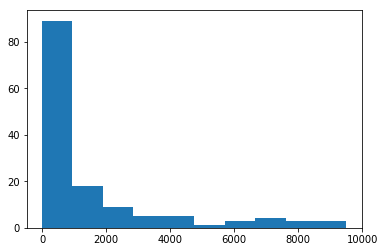

In [49]:
# Regression
data_sampled = data[data.target < 10000] # Remove Outliers
plt.hist(data_sampled['target'])

In [50]:
# Transform categorical features into the appropriate type that is expected by LightGBM.
for c in data_sampled.columns:
    col_type = data_sampled[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data_sampled[c] = data_sampled[c].astype('category')

In [51]:
# Data Skew: log transformation
# y_all = data_sampled['target']
y_all = np.log(data_sampled['target'])

(array([ 1.,  0., 11., 15., 16., 11., 21., 24., 22., 19.]),
 array([0.       , 0.9159994, 1.8319988, 2.7479982, 3.6639976, 4.579997 ,
        5.4959964, 6.4119958, 7.3279952, 8.2439946, 9.159994 ]),
 <a list of 10 Patch objects>)

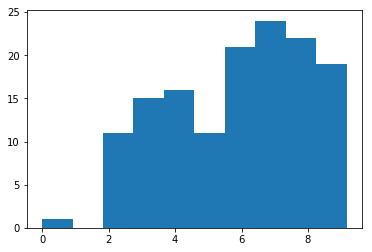

In [52]:
plt.hist(y_all)

In [53]:
X_all = data_sampled.loc[:, data_sampled.columns != 'target']

# Feature Analysis by Correlation

In [54]:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

corr = X_all.corr()
corr.replace(np.nan, 0, inplace=True)
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr

,SG.VAW.1549.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REAS.ZS,SG.VAW.REFU.ZS,SH.ACS.ALON.Q1.ZS,SH.ACS.ALON.Q2.ZS,SH.ACS.ALON.Q3.ZS,...,SP.UWT.SPCG.Q2.ZS,SP.UWT.SPCG.Q3.ZS,SP.UWT.SPCG.Q4.ZS,SP.UWT.SPCG.Q5.ZS,SP.UWT.TFRT,SP.UWT.TFRT.Q1.ZS,SP.UWT.TFRT.Q2.ZS,SP.UWT.TFRT.Q3.ZS,SP.UWT.TFRT.Q4.ZS,SP.UWT.TFRT.Q5.ZS
SG.VAW.1549.ZS,1.000000,0.632691,0.369748,0.660453,0.574754,0.661894,0.556158,0.291630,0.387004,0.383504,...,0.468892,0.477597,0.535468,0.427872,0.345668,0.296284,0.307994,0.288913,0.338130,0.295565
SG.VAW.ARGU.ZS,0.632691,1.000000,0.842688,0.975736,0.934296,0.965015,0.918762,0.282301,0.348444,0.316732,...,0.420470,0.412334,0.484095,0.513195,0.204262,0.263311,0.232098,0.212140,0.248073,0.297772
SG.VAW.BURN.ZS,0.369748,0.842688,1.000000,0.875674,0.900147,0.865325,0.799946,0.135711,0.209661,0.209439,...,0.413839,0.383825,0.460978,0.548410,0.275077,0.290328,0.297140,0.249179,0.286907,0.350918
SG.VAW.GOES.ZS,0.660453,0.975736,0.875674,1.000000,0.960679,0.979575,0.889839,0.310882,0.373740,0.351501,...,0.399038,0.372700,0.445806,0.515526,0.272811,0.266272,0.233649,0.191459,0.232877,0.313754
SG.VAW.NEGL.ZS,0.574754,0.934296,0.900147,0.960679,1.000000,0.978231,0.892039,0.290661,0.358885,0.348502,...,0.380728,0.346134,0.417177,0.502038,0.296154,0.323176,0.275972,0.221057,0.260805,0.328878
SG.VAW.REAS.ZS,0.661894,0.965015,0.865325,0.979575,0.978231,1.000000,0.918052,0.314544,0.391383,0.373028,...,0.404545,0.376711,0.439810,0.492204,0.277591,0.316055,0.269007,0.221630,0.257789,0.307400
SG.VAW.REFU.ZS,0.556158,0.918762,0.799946,0.889839,0.892039,0.918052,1.000000,0.109164,0.167642,0.130132,...,0.392837,0.363714,0.441281,0.491564,0.224580,0.209874,0.183573,0.156832,0.214968,0.251403
SH.ACS.ALON.Q1.ZS,0.291630,0.282301,0.135711,0.310882,0.290661,0.314544,0.109164,1.000000,0.977189,0.947036,...,0.077830,0.092537,0.072186,-0.053469,0.147490,0.233253,0.156849,0.156985,0.141118,0.046041
SH.ACS.ALON.Q2.ZS,0.387004,0.348444,0.209661,0.373740,0.358885,0.391383,0.167642,0.977189,1.000000,0.980666,...,0.159945,0.156441,0.136938,-0.001399,0.192334,0.300529,0.225970,0.202440,0.193759,0.085458
SH.ACS.ALON.Q3.ZS,0.383504,0.316732,0.209439,0.351501,0.348502,0.373028,0.130132,0.947036,0.980666,1.000000,...,0.118232,0.117456,0.110580,-0.015685,0.147408,0.238806,0.168406,0.153941,0.156305,0.072548


# Modelling with LGBM Regressor

In [55]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=20200502)

## Hyperparameter optimization

In [56]:
# Number of CPUs
multiprocessing.cpu_count()

2

In [57]:
# LGBM initial param
# Please refer to https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

reg_grid = lgb.LGBMRegressor(objective = 'regression',
                             boosting = 'gbdt',
                             verbosity = -1,
                             random_seed = 20200501,
                             n_estimators = 5000,
                            )

gridParams = {
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'metric' : ['regression_l2', 'l2', 'l1']
}

# Grid search
grid = RandomizedSearchCV(reg_grid, gridParams, verbose=2, cv=4, n_jobs = 2*multiprocessing.cpu_count()) 
grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   33.9s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=31,
       objective='regression', random_seed=20200501, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'min_data_in_leaf': [10, 20, 40, 60, 100], 'max_depth': [3, 4, 5, 6, 8, 12, 16, -1], 'metric': ['regression_l2', 'l2', 'l1']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [58]:
pickling_on = open("grid_model.pickle","wb")
pickle.dump(grid, pickling_on, protocol=4)
pickling_on.close()

## Train with Best Hyperparameters

In [59]:
# Load best model
pickle_off = open("grid_model.pickle","rb")
grid = pickle.load(pickle_off)

In [60]:
# Configure LGBM with best param
def set_reg():
    reg = lgb.LGBMRegressor(objective = 'regression',
                             boosting = 'gbdt',
                             verbosity = -1,
                             random_seed = 20200501,
                             n_estimators = 5000,
                             min_data_in_leaf = grid.best_params_['min_data_in_leaf'], 
                             max_depth = grid.best_params_['max_depth'], 
                             metric = grid.best_params_['metric'],  
                             n_jobs= 2*multiprocessing.cpu_count()
                            ) 
    return reg

In [61]:
X_train.shape

(112, 572)

In [62]:
# Run LGBM again with best param
reg = set_reg() 
reg.fit(X_train, y_train)
importances = reg.feature_importances_
importances

array([ 15,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  22, 248, 115, 144, 181,
        47,   0,   4,  23,   1, 102,   0,  88,   4,   9,  65,  26,   0,
         0,   5,   1,   1,   0,   0,   0,   0,   0,  24, 137, 253,  17,
         0,   0,   0,   0,   0,  42,   0,   6,   0,   9,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  15,   0,   0,   0,   5,   0,   0,   0,   0,
         0,   0,  29,   5,  98,  20,   3,   0,  19, 372,  28,  28,   9,
        61,  15,  19,   8,  35,   4,   0,   0,   0,   0,   0,  36,   0,
         0,   0,   0,   0,  38,   0,   0,   0,   0,   0,  40,   0,   0,
         5,   0,   0,   0,   0,   0,   0,   0,   0,   0, 116, 276, 194,
        18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

# Feature Exploration and Analysis

In [63]:
feature_imp = pd.DataFrame(sorted(zip(reg.feature_importances_,X_train.columns), reverse=True), columns=['Value','Feature'])
feature_imp.shape

(572, 2)

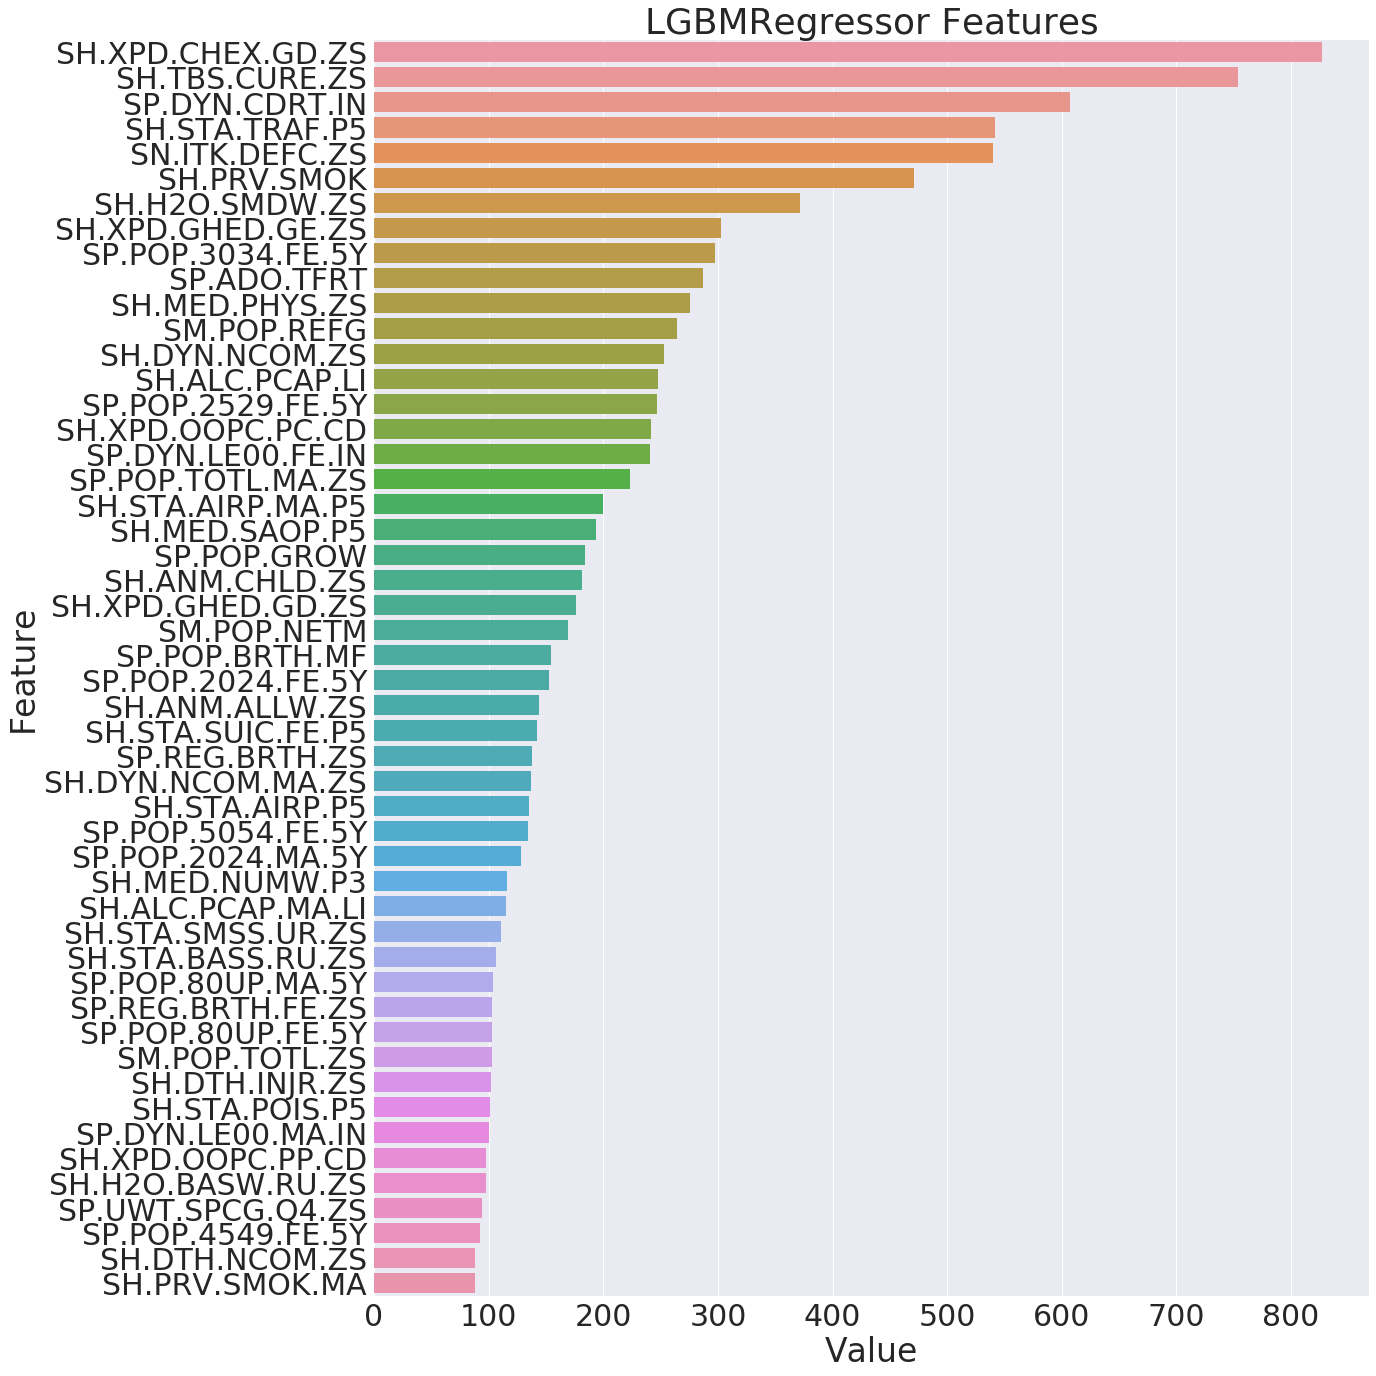

In [64]:
plt.figure(figsize=(20, 20))
n_best_features = 50
sns.set(font_scale=3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[0:n_best_features,:])
plt.title('LGBMRegressor Features')
plt.tight_layout()
plt.savefig("LGBMRegressor_feature_importances.png")
plt.show()

In [65]:
# Identify the important features
sorter = feature_imp.sort_values(by="Value", ascending=False).iloc[0:n_best_features,:]
imp_features = indicators_list[indicators_list['id'].isin(sorter['Feature'])]

join_imp_features = pd.merge(imp_features, sorter, how = 'inner', left_on='id', right_on='Feature')
join_imp_features.sort_values(by=['Value'], ascending=False, inplace=True)

join_imp_features.head(10)

,id,name,unit,source,sourceNote,sourceOrganization,topics,Value,Feature
23,SH.XPD.CHEX.GD.ZS,Current health expenditure (% of GDP),,World Development Indicators,Level of current health expenditure expressed ...,World Health Organization Global Health Expend...,Health,827,SH.XPD.CHEX.GD.ZS
22,SH.TBS.CURE.ZS,Tuberculosis treatment success rate (% of new ...,,World Development Indicators,Tuberculosis treatment success rate is the per...,"World Health Organization, Global Tuberculosis...",Health,754,SH.TBS.CURE.ZS
33,SP.DYN.CDRT.IN,"Death rate, crude (per 1,000 people)",,World Development Indicators,Crude death rate indicates the number of death...,(1) United Nations Population Division. World ...,Health,607,SP.DYN.CDRT.IN
21,SH.STA.TRAF.P5,Mortality caused by road traffic injury (per 1...,,World Development Indicators,Mortality caused by road traffic injury is est...,"World Health Organization, Global Status Repor...","Health ,Urban Development",542,SH.STA.TRAF.P5
31,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),,World Development Indicators,Population below minimum level of dietary ener...,Food and Agriculture Organization (http://www....,Health,540,SN.ITK.DEFC.ZS
13,SH.PRV.SMOK,"Smoking prevalence, total (ages 15+)",,World Development Indicators,Prevalence of smoking is the percentage of men...,"World Health Organization, Global Health Obser...",Health,471,SH.PRV.SMOK
9,SH.H2O.SMDW.ZS,People using safely managed drinking water ser...,,World Development Indicators,The percentage of people using drinking water ...,WHO/UNICEF Joint Monitoring Programme (JMP) fo...,"Health ,Environment",372,SH.H2O.SMDW.ZS
25,SH.XPD.GHED.GE.ZS,Domestic general government health expenditure...,,World Development Indicators,Public expenditure on health from domestic sou...,World Health Organization Global Health Expend...,Health,303,SH.XPD.GHED.GE.ZS
39,SP.POP.3034.FE.5Y,"Population ages 30-34, female (% of female pop...",,World Development Indicators,Female population between the ages 30 to 34 as...,World Bank staff estimates based on age/sex di...,Health,297,SP.POP.3034.FE.5Y
32,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 wo...",,World Development Indicators,Adolescent fertility rate is the number of bir...,"United Nations Population Division, World Popu...","Health ,Gender,Social Development",287,SP.ADO.TFRT


In [66]:
sorter.head()

,Value,Feature
0,827,SH.XPD.CHEX.GD.ZS
1,754,SH.TBS.CURE.ZS
2,607,SP.DYN.CDRT.IN
3,542,SH.STA.TRAF.P5
4,540,SN.ITK.DEFC.ZS


# SHAP Analysis

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


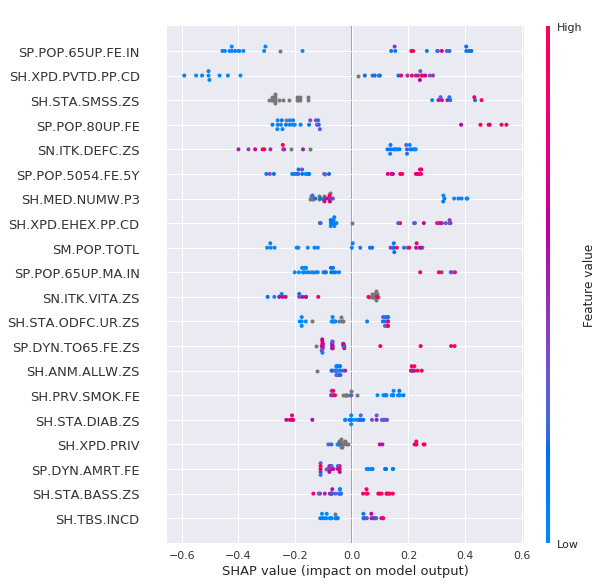

In [67]:
# https://github.com/slundberg/shap/blob/master/README.md
# load JS visualization code to notebook
shap.initjs()

Explainer = shap.TreeExplainer(reg)
shap_values = Explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Performance Analysis

## Training Accuracy

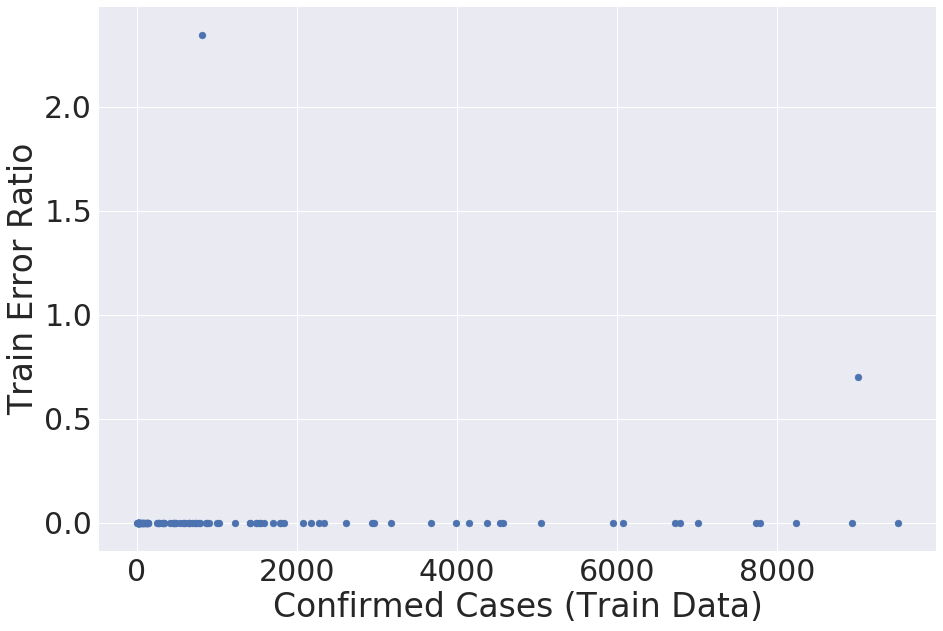

In [68]:
# Training Accuracy

pred_y_train = reg.predict(X_train)
train_error = abs(np.exp(y_train) - np.exp(pred_y_train))
train_error_ratio = (train_error/np.exp(y_train))

plt.scatter(np.exp(y_train), train_error_ratio)
fig = plt.gcf()
plt.ylabel('Train Error Ratio')
plt.xlabel('Confirmed Cases (Train Data)')
fig.set_size_inches(15, 10)

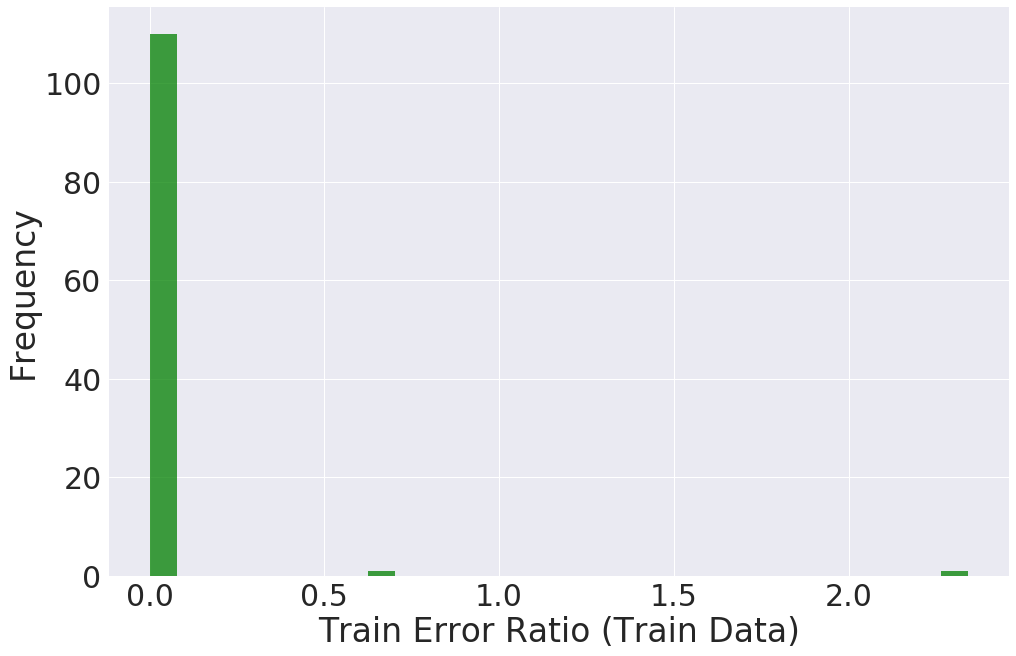

In [69]:
# Select Finite Values
train_error_temp = train_error_ratio[np.isfinite(train_error_ratio)]

plt.hist(train_error_temp, bins=30, facecolor='green', alpha=0.75)
fig = plt.gcf()
plt.ylabel('Frequency')
plt.xlabel('Train Error Ratio (Train Data)')
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.savefig("Train Error Ratio.png")
plt.show()

## Test Accuracy

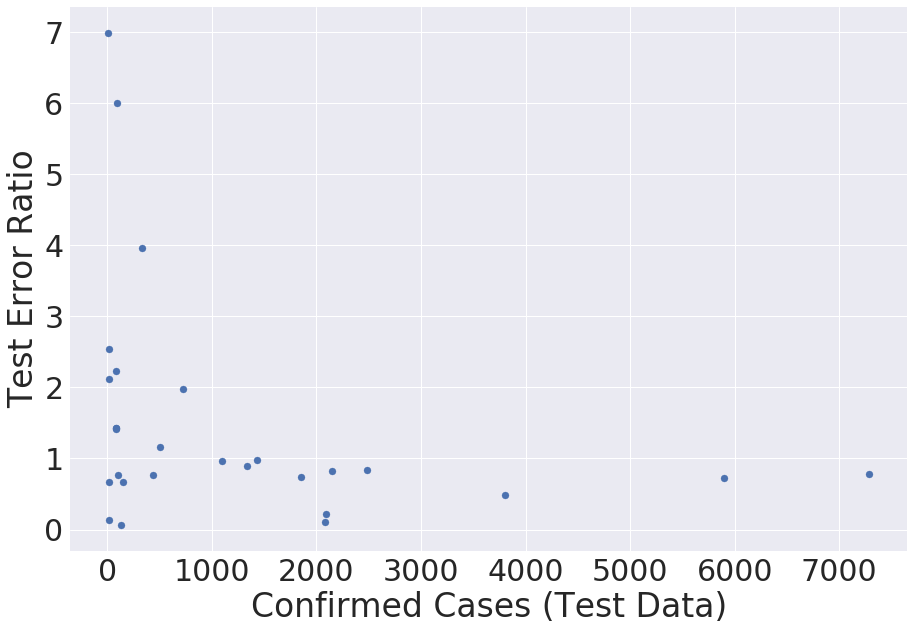

In [70]:
# Test Accuracy

pred_y_test = reg.predict(X_test)
test_error = abs(np.exp(y_test) - np.exp(pred_y_test))
test_error_ratio = (test_error/np.exp(y_test))

plt.scatter(np.exp(y_test), test_error_ratio)
fig = plt.gcf()
plt.ylabel('Test Error Ratio')
plt.xlabel('Confirmed Cases (Test Data)')
fig.set_size_inches(15, 10)

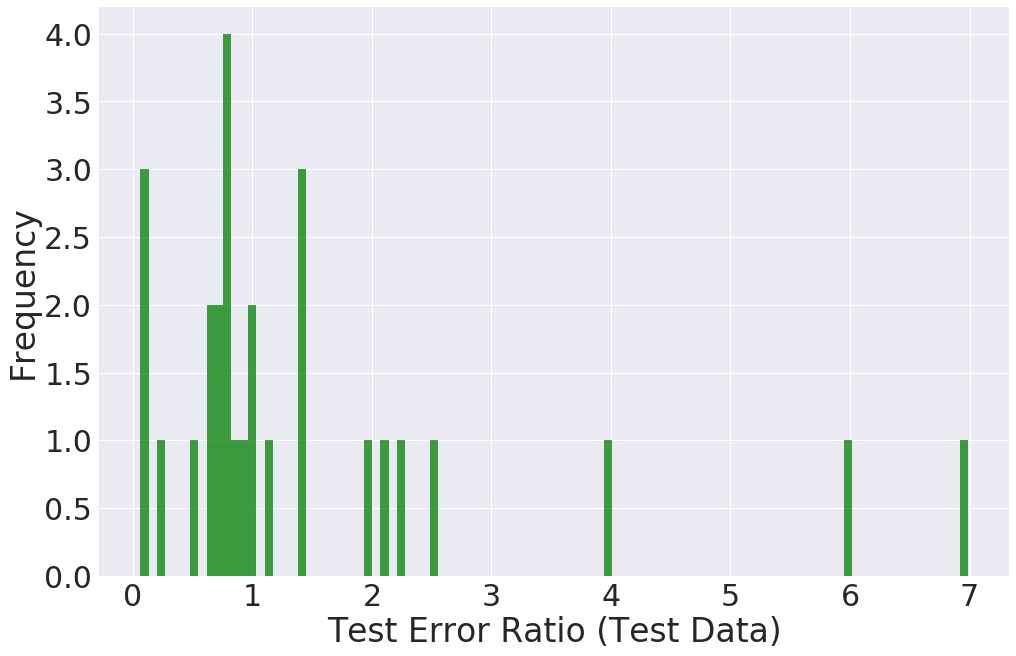

In [71]:
test_error_temp = test_error_ratio[np.isfinite(test_error_ratio)]

plt.hist(test_error_temp, bins=100, facecolor='green', alpha=0.75)
fig = plt.gcf()
plt.ylabel('Frequency')
plt.xlabel('Test Error Ratio (Test Data)')
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.savefig("Test Error Ratio 2.png")
plt.show()